In [6]:
import os

repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
from scipy.stats import spearmanr

import pickle
import pandas as pd
import sklearn 
import sys
import pandas as pd
from importlib import reload
import copy

import warnings

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns

from mosaiks.utils.imports import *

# Key prediction functions are here
from analysis.prediction_utils import predict_y_from_kfold_dict
from analysis.prediction_utils import make_train_pred_scatterplot as make_scatterplot


import geopandas as gpd
import shapely

## Link DHS clusters to parent ADM1 regions

We need to be able to connect the DHS cluster level data to the correct parent ADM1 polygon

### Read region codes data for spatial merge (iso2  to iso3 converstion)

In [9]:
r = pd.read_csv(data_dir +"raw/region_codes/region_codes.csv")[["alpha-2","alpha-3"]]

In [10]:
#The following set of iso2 codes are inconsistent from the DHS data. We will manually add them
manual_rename = {"BU":"BDI","NM":"NAM", "DR":"DOM","IA":"IND"}

In [11]:
stack = pd.DataFrame(manual_rename, index=[0]).T.reset_index()
stack.columns = r.columns

In [12]:
r = pd.concat([r,stack]).reset_index(drop=True)

### Read IWI data at DHS cluser

These DHS cluser level IWI data were proviced by GPL.

In [13]:
iwi =  pd.read_csv(data_dir + '/int/GDL_IWI/mean_IWI.csv').groupby("DHSID").mean()

## Step 1 -  Link DHS polygons to ADM1 units

In [7]:
temp_shp = pd.read_pickle(data_dir + "int/GDL_IWI/DHS_iwi_cluster_buffers_clipped.p").set_index("DHSID")
dhs_shp = temp_shp.loc[iwi.index].reset_index()



In [8]:
## add a 3 character iso code to DHS

dhs_shp["iso2"] = dhs_shp["surveyID"].apply(lambda x : x[:2])
dhs_shp = dhs_shp.merge(r[["alpha-2","alpha-3"]], how="left", left_on="iso2", right_on="alpha-2")

<AxesSubplot:>

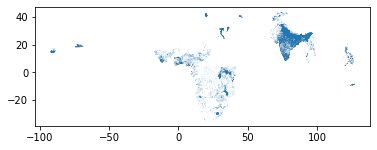

In [9]:
dhs_shp.plot()

In [14]:
shapefile_path = data_dir + "raw/GDL_HDI/GDL_Shapefiles_V4/GDL_Shapefiles_V4.shp"
gpdf = gpd.read_file(shapefile_path)

In [11]:
def get_adm1_adm2_intersection_for_country(country_code, adm1, adm2, adm2_country_col_name="alpha-3"):
    adm1_subset = adm1[adm1["iso_code"] == country_code]
    adm2_subset = adm2[adm2[adm2_country_col_name] == country_code]
    
    overlaps_list = []
    percentages_list = []

    for adm2_geometry in adm2_subset["geometry"]:
        bools = adm1_subset.intersects(adm2_geometry)
        overlaps = list(adm1_subset["GDLcode"].loc[bools])
        percentages = list(adm1_subset.loc[bools].intersection(adm2_geometry).area / adm2_geometry.area)

        overlaps_list.append(overlaps)
        percentages_list.append(percentages)

    adm2_subset_copy = adm2_subset.copy()
    adm2_subset_copy["overlaps"] = overlaps_list
    adm2_subset_copy["percent_overlaps"] = percentages_list
    
    return adm2_subset_copy

In [12]:
dhs_countries = dhs_shp["alpha-3"].unique()

In [13]:
dhs_countries

array(['ALB', 'ARM', 'AGO', 'BGD', 'BEN', 'BDI', 'COD', 'CMR', 'DOM',
       'EGY', 'GAB', 'GHA', 'GIN', 'GUM', 'HTI', 'IND', 'JOR', 'KEN',
       'CYM', 'LSO', 'MLI', 'MMR', 'MWI', 'MOZ', 'NGA', 'NAM', 'NPL',
       'PHL', 'PAK', 'RWA', 'SLE', 'SEN', 'TCD', 'TGO', 'TJK', 'TLS',
       'TZA', 'UGA', 'ZAF', 'ZMB', 'ZWE'], dtype=object)

In [ ]:
# slow code below has been commented out and an intermediate file saved

In [26]:
# dfs = []

# for country_code in dhs_countries:
    
#     dfs.append(get_adm1_adm2_intersection_for_country(country_code,gpdf,dhs_shp))
# link_df = pd.concat(dfs)

In [27]:
link_df.head()

,DHSID,DHSCLUST,DHSREGCO,DHSREGNA,ADM1DHS,ADM1NAME,URBAN_RURA,LATNUM,LONGNUM,DHSREGEN,REGCODE,REGNAME,surveyID,regionID,geometry,iso2,alpha-2,alpha-3,overlaps,percent_overlaps
0,AL201700000001,1.0,1.0,Berat,1.0,Berat,U,40.710440,19.946651,Berat,1.0,Berat,AL_2017_DHS,AL_2017_DHS_REGCODE_1,"POLYGON ((19.97040 40.71044, 19.97028 40.70868...",AL,AL,ALB,[ALBr201],[1.0]
1,AL201700000002,2.0,1.0,Berat,1.0,Berat,U,40.706556,19.928871,Berat,1.0,Berat,AL_2017_DHS,AL_2017_DHS_REGCODE_1,"POLYGON ((19.95262 40.70656, 19.95250 40.70479...",AL,AL,ALB,[ALBr201],[1.0]
2,AL201700000003,3.0,1.0,Berat,1.0,Berat,U,40.699880,19.941165,Berat,1.0,Berat,AL_2017_DHS,AL_2017_DHS_REGCODE_1,"POLYGON ((19.96491 40.69988, 19.96479 40.69812...",AL,AL,ALB,[ALBr201],[1.0]
3,AL201700000004,4.0,1.0,Berat,1.0,Berat,U,40.706846,19.935033,Berat,1.0,Berat,AL_2017_DHS,AL_2017_DHS_REGCODE_1,"POLYGON ((19.95878 40.70685, 19.95866 40.70508...",AL,AL,ALB,[ALBr201],[1.0]
4,AL201700000005,5.0,1.0,Berat,1.0,Berat,U,40.711084,19.945552,Berat,1.0,Berat,AL_2017_DHS,AL_2017_DHS_REGCODE_1,"POLYGON ((19.96930 40.71108, 19.96918 40.70932...",AL,AL,ALB,[ALBr201],[1.0]


In [28]:
link_path = data_dir + "int/DHS_to_GDL_ADM1_link/int_file_dhsid_to_gdl_adm1_link.p"
#link_df.to_pickle(link_path)
link_df = pd.read_pickle(link_path)

In [29]:
link_df_clean = link_df[link_df["overlaps"].apply(len) != 0].copy()

In [30]:
no_overlap_count = len(link_df)- len(link_df_clean)
print(no_overlap_count, "observations do not overlap an ADM1 region" )
print("We drop these, representing", round(no_overlap_count/len(link_df) * 100,2), " percent of the data")

1197 observations do not overlap an ADM1 region
We drop these, representing 2.25  percent of the data


In [32]:
arg_maxes = link_df_clean["percent_overlaps"].apply(np.argmax)
parent_adm1 = [link_df_clean["overlaps"].iloc[i][item] for i,item in enumerate(arg_maxes)]
perc_overlap = [link_df_clean["percent_overlaps"].iloc[i][item] for i,item in enumerate(arg_maxes)]


In [33]:
link_df_clean["GDL_adm1_parent"] = parent_adm1
link_df_clean["perc_overlap_with_parent"] = perc_overlap

In [34]:
link_df_clean.to_pickle(data_dir + "int/DHS_to_GDL_ADM1_link/dhsid_to_gdl_adm1_link.p")

Text(0.5, 1.0, '% overlap between DHS polygons and their parent ADM1 region')

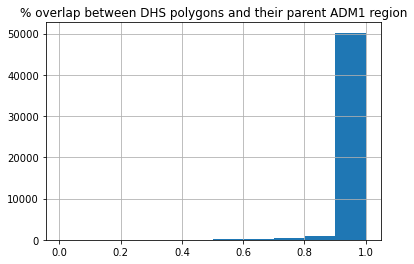

In [39]:
link_df_clean["perc_overlap_with_parent"].hist()

plt.title("% overlap between DHS polygons and their parent ADM1 region")

In [56]:
print( "There are just", (link_df_clean["perc_overlap_with_parent"] < .5).sum(),
" DHS IWI obs that have less than 50% overlap with an ADM1 region" )

There are just 71  DHS IWI obs that have less than 50% overlap with an ADM1 region
